# Logistic regression

In [260]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import random

import seaborn as sns
plt.style.use('fivethirtyeight')


In [261]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [262]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score #ordinary linear regression + w/ ridge regularization

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [263]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])


In [264]:
df = pd.read_pickle('data/users_train.pkl')

**View the data**

In [300]:
grid={"C":np.logspace(-3,3,7)}

In [301]:
grid

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [265]:
#dest_bookings = Xtrain.groupby(['country_destination'])['id'].count().reset_index()
#dest_bookings = dest_bookings[dest_bookings['country_destination'] != 'NDF']
#dest_bookings['pct_of_total'] = [(x/dest_bookings['id'].sum())*100 for x in dest_bookings['id']]
#dest_bookings = dest_bookings.sort_values(by='pct_of_total', ascending = False)
#dest_bookings

In [266]:
dest_bookings = df.groupby(['country_destination'])['id'].count().reset_index()
dest_bookings = dest_bookings[dest_bookings['country_destination'] != 'NDF']
dest_bookings['pct_of_total'] = [(x/dest_bookings['id'].sum())*100 for x in dest_bookings['id']]
dest_bookings = dest_bookings.sort_values(by='pct_of_total', ascending = False)
dest_bookings

,country_destination,id,pct_of_total
10,US,62376,70.157916
11,other,10094,11.353309
4,FR,5023,5.649660
6,IT,2835,3.188689
5,GB,2324,2.613938
3,ES,2249,2.529581
1,CA,1428,1.606155
2,DE,1061,1.193368
8,NL,762,0.857066
0,AU,539,0.606245


**Create two target classes (USA/Canada vs. rest of world)**

In [267]:
dest_bookings.country_destination.unique()

array(['US', 'other', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU',
       'PT'], dtype=object)

In [268]:
dest_dict = {'US': 'USA', 'other':'WLD', 'FR':'WLD', 'IT':'WLD', 
             'GB':'WLD', 'ES':'WLD', 'CA':'USA', 'DE':'WLD', 'NL':'WLD', 'AU':'WLD','PT':'WLD'}
dest_bi = {'USA':1, 'WLD':0}

In [269]:
df['country_USA_World'] = df['country_destination'].map(dest_dict)
df['country_USA_World_bi'] = df['country_USA_World'].map(dest_bi)

In [270]:
df['country_USA_World_bi'].value_counts()/df['country_USA_World_bi'].value_counts().sum()

1.0    0.717641
0.0    0.282359
Name: country_USA_World_bi, dtype: float64

**Define X features and y target**

In [271]:
#df.columns

In [272]:
df.head(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app_2_ios,signup_app_2_moweb,secs_elapsed_mean,secs_elapsed_std,num_different_devices,num_different_actions,num_sessions,first_action_type,country_USA_World,country_USA_World_bi
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,unknown,NaN,facebook,0.0,en,direct,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
#df.dtypes

In [274]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']

X = df.select_dtypes(include=numerics)
X = X.drop(['country_dest_id','country_USA_World_bi'], axis = 1)

In [275]:
X.columns

Index(['age', 'signup_flow', 'gender_female', 'gender_male', 'gender_other',
       'signup_method_basic', 'signup_method_facebook', 'language_ca',
       'language_cs', 'language_da', 'language_de', 'language_el',
       'language_en', 'language_es', 'language_fi', 'language_fr',
       'language_hr', 'language_hu', 'language_id', 'language_is',
       'language_it', 'language_ja', 'language_ko', 'language_nl',
       'language_no', 'language_pl', 'language_pt', 'language_ru',
       'language_sv', 'language_th', 'language_tr', 'year_created',
       'month_created', 'day_created', 'year_active', 'month_active',
       'day_active', 'year_first_booking', 'month_first_booking',
       'day_first_booking', 'lag_book_create', 'lag_active_create',
       'affiliate_channel_2_brand', 'affiliate_channel_2_direct',
       'affiliate_provider_2_direct', 'affiliate_provider_2_google',
       'first_affiliate_tracked_2_linked', 'first_affiliate_tracked_2_omg',
       'first_affiliate_tracked_2_

In [276]:
y_bi = df['country_USA_World_bi']
y_mlt = df['country_dest_id']       

**What do do about null values?**

In [277]:
#df['age'] = pd.to_numeric(df['age'], errors = 'coerce')
#df.loc[df.age > 100, 'age'] = np.nan
#df.loc[df.age < 16, 'age'] = np.nan
#df = df.fillna(median,inplace=True)

df['age'].describe()

count    122659.000000
mean         36.438036
std          11.355767
min          18.000000
25%          28.000000
50%          33.000000
75%          42.000000
max          85.000000
Name: age, dtype: float64

In [278]:
# Number of rows
len(df)

213451

In [279]:
# No data from sessions
df1 = df[df.secs_elapsed_mean.isna() == True]
len(df1)

140820

In [280]:
# Predicting data: sessions info but no age
df2 = df[(df.secs_elapsed_mean.isna() == False) & (df.age.isna() == True)]
len(df2)

32380

In [281]:
# Training data: sessions info and age
df3 = df[(df.secs_elapsed_mean.isna() == False) & (df.age.isna() == False)]
len(df3)

40251

In [282]:
(len(df1)+len(df2)+len(df3))/len(df)

1.0

In [283]:
age_reg = LinearRegression()
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

def r2_adj(X,Y,r_squared):
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return(adjusted_r_squared)

from statistics import mean

In [284]:
df_train_age = df3.drop(['year_first_booking',
                  'month_first_booking',
                  'day_first_booking',
                  'lag_book_create'], axis = 1)
df3_no_na = df_train_age[df_train_age.isnull().any(1) == False ]
df3_w_na = df_train_age[df_train_age.isnull().any(1) == True ]
print(len(df3_no_na), len(df3_w_na))

18541 21710


In [285]:

age_reg_X = sm.add_constant(df3_no_na.drop('age', axis=1), has_constant='add')
age_reg_y = df3_no_na['age']

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [286]:
age_reg_X = age_reg_X.select_dtypes(include=numerics)

In [287]:
age_reg_X.head()

,const,signup_flow,gender_female,gender_male,gender_other,signup_method_basic,signup_method_facebook,language_ca,language_cs,language_da,...,first_browser_2_other,signup_app_2_android,signup_app_2_ios,signup_app_2_moweb,secs_elapsed_mean,secs_elapsed_std,num_different_devices,num_different_actions,num_sessions,country_USA_World_bi
137027,1.0,0.0,1,0,0,0,1,0,0,0,...,1,0,0,0,8278.833333,18615.345653,2.0,4.0,7.0,1.0
137029,1.0,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,30580.976190,106557.129472,1.0,12.0,43.0,0.0
137032,1.0,0.0,1,0,0,0,1,0,0,0,...,1,0,0,0,52458.142857,128053.626024,2.0,7.0,8.0,1.0
137056,1.0,0.0,0,1,0,1,0,0,0,0,...,0,0,0,0,51844.500000,87349.723199,2.0,14.0,17.0,1.0
137057,1.0,0.0,1,0,0,1,0,0,0,0,...,0,0,0,0,55788.807018,145277.628453,1.0,18.0,58.0,1.0


In [288]:
nan_rows = age_reg_X[age_reg_X.isnull().any(1)]
len(nan_rows)/len(age_reg_X)

0.0

In [289]:
age_reg_X.shape

(18541, 64)

In [290]:
age_reg_y.shape

(18541,)

In [291]:
#(age_reg_X.isna().sum())/len(age_reg_X)

In [292]:
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(age_reg_X, age_reg_y, test_size=.2, random_state=10)


from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state = 101)

In [293]:
age_reg = sm.OLS(y_train_age, X_train_age)
fit = age_reg.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     29.84
Date:                Tue, 05 Feb 2019   Prob (F-statistic):          4.04e-270
Time:                        15:39:58   Log-Likelihood:                -56274.
No. Observations:               14832   AIC:                         1.127e+05
Df Residuals:                   14780   BIC:                         1.130e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             4.226e-06   2.45e-07     17.259      0.000    3.75e-06    4.71e-06
signup_flow                         -0.0055      0.034     -0.161      0.872      -0.073       0.062
gender_female                       -0.9961      0.248     -4.025      0.000      -1.481      -0.511
gender_male                          0.5116      0.255      2.005      0.045       0.012       1.012
gender_other                        -0.2514      1.949     -0.129      0.897      -4.071       3.568
signup_method_basic                 -0.6562      1.546     -0.425      0.671      -3.686       2.374
signup_method_facebook              -2.6508      1.549     -1.711      0.087      -5.687       0.385
language_ca                      -7.581e-10   7.87e-10     -0.963      0.336    -2.3e-09    7.85e-10
language_cs                       6.816e-12   1.42e-11      0.479      0.632   -2.11e-11    3.47e-11
language_da                      -1.152e-10   8.38e-11     -1.374      0.169    -2.8e-10    4.91e-11
language_de                          0.4916      1.838      0.268      0.789      -3.110       4.093
language_el                          1.1241      5.472      0.205      0.837      -9.601      11.849
language_en                          4.0174      0.951      4.223      0.000       2.153       5.882
language_es                          2.5973      1.899      1.368      0.171      -1.124       6.319
language_fi                          5.5399      7.686      0.721      0.471      -9.525      20.605
language_fr                         -3.4612      1.771     -1.955      0.051      -6.932       0.009
language_hr                      -2.923e-09   4.02e-09     -0.728      0.467   -1.08e-08    4.95e-09
language_hu                         -2.7572     10.823     -0.255      0.799     -23.972      18.458
language_id                       3.071e-14   4.49e-14      0.683      0.494   -5.74e-14    1.19e-13
language_is                       4.351e-14   3.48e-14      1.251      0.211   -2.47e-14    1.12e-13
language_it                          0.4587      2.787      0.165      0.869      -5.004       5.921
language_ja                          3.2982      3.033      1.088      0.277      -2.646       9.243
language_ko                         -0.6284      1.934     -0.325      0.745      -4.419       3.162
language_nl                          6.3724      5.474      1.164      0.244      -4.357      17.101
language_no                         10.7075     10.853      0.987      0.324     -10.565      31.980
language_pl                          0.2911     10.819      0.027      0.979     -20.916      21.498
language_pt                          3.5829      3.137      1.142      0.253      -2.567       9.732
language_ru                         -0.5323      2.94

In [294]:
age_pred = fit.predict(X_test_age)

In [295]:
mae(y_test_age, age_pred)

8.171919829871465

Text(0, 0.5, 'Actual')

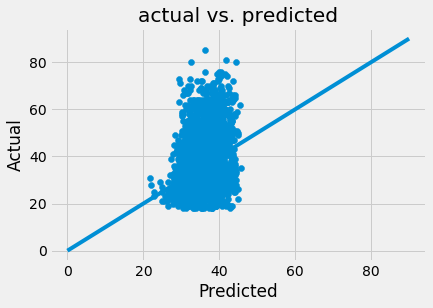

In [296]:
plt.scatter(age_pred,y_test_age)
plt.plot([0,90],[0,90])
plt.title("actual vs. predicted")
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [297]:
age_pred = fit.predict(X_test_age)
age_mean = y_train_age.mean()
age_median = y_train_age.median()
age_mode = y_train_age.mode()
age_mode

0    30.0
dtype: float64

In [298]:
print('OLS:',mae(y_test_age, age_pred),
      'Mean:',mae(y_test_age, age_mean),
      'Median:',mae(y_test_age, age_median),
      'Mode:',mae(y_test_age, 30)
     )

OLS: 8.171919829871465 Mean: 8.562897768569714 Median: 8.095173901321111 Mode: 8.270423294688594


In [299]:
df.to_pickle('data/users_train.pkl')